# What needs to be double-checked

- whether `convert dtypes (automatically)` works properly on new data - it's commented out, because `Int64` dtype is not supported compared to default `int64`
- whether `get names of categorical columns (automatically)` works properly on new data

# Imports

In [1]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt

# Constants

In [2]:
TEST_PERCENTAGE = 0.3

# Setting up device

In [3]:
# device = torch.device("cuda:2") 
# device
# device = torch.device("mps")
device = torch.device("cpu")
device

device(type='cpu')

# Seeds

In [4]:
# if torch.cuda.is_available(): 
#     torch.cuda.manual_seed(42)
#     torch.cuda.manual_seed_all(42)
    
# torch.backends.cudnn.determinstic = True
# torch.backends.cudnn.benchmark = False

import os
import random

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

# Get Data

In [5]:
adults_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",header=None)

In [6]:
# set columns' names
adults_data.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "label"]

## EDA (Exploratory Data Analysis)

In [7]:
adults_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [8]:
adults_data.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
label                 2
dtype: int64

In [9]:
# drop columns
# adults_data.drop(columns=["native-country","education","workclass","relationship", "marital-status","race"],inplace=True)

# Data preparation

In [10]:
# convert columns with 2 classes to binary
adults_data.sex = (adults_data.sex==' Male').astype(int)
adults_data.label = (adults_data.label==' >50K').astype(int)

In [11]:
adults_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  int64 
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  label           32561 non-null  int64 
dtypes: int64(8), object(7)
memory usage: 3.7+ MB


In [12]:
# convert dtypes (automatically) - commented out, because Int64 gives an error later when converting to tensor
# adults_data = adults_data.convert_dtypes()
# adults_data.info()

In [13]:
# get names of categorical columns (automatically)
categorical_columns = adults_data.dtypes[(adults_data.dtypes == 'string') | (adults_data.dtypes == 'object')].index.to_list()

In [14]:
# one-hot encoding on categorical columns
categorical_values = pd.get_dummies(adults_data[categorical_columns])
categorical_values.head()

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# check if number of columns in categorical values is good
assert(len(categorical_values.columns) == adults_data[categorical_columns].nunique().sum())

In [16]:
# drop categorical_columns from adults_data
adults_data = adults_data.drop(columns=categorical_columns)

In [17]:
# create indices for splitting data into train and test
train_indices = np.random.rand(len(adults_data)) > TEST_PERCENTAGE
np.unique(train_indices, return_counts=True)

(array([False,  True]), array([ 9740, 22821]))

In [18]:
adults_data

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,label
0,39,77516,13,1,2174,0,40,0
1,50,83311,13,1,0,0,13,0
2,38,215646,9,1,0,0,40,0
3,53,234721,7,1,0,0,40,0
4,28,338409,13,0,0,0,40,0
...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,0,38,0
32557,40,154374,9,1,0,0,40,1
32558,58,151910,9,0,0,0,40,0
32559,22,201490,9,1,0,0,20,0


In [19]:
# create tensors for numerical, categorical and target data (train)
numerical_data = torch.from_numpy(adults_data.values[train_indices,:-1]).float()
categorical_data = torch.from_numpy(categorical_values.values[train_indices]).float()
targets = torch.from_numpy(adults_data.values[train_indices,-1]).float()

# create tensors for numerical, categorical and target data (test)
test_numerical_data = torch.from_numpy(adults_data.values[~train_indices,:-1]).float()
test_categorical_data = torch.from_numpy(categorical_values.values[~train_indices]).float()
test_targets = torch.from_numpy(adults_data.values[~train_indices,-1]).float()

# create datasets from previously created tensors
train_dataset = data.TensorDataset(numerical_data,categorical_data,targets)
test_dataset = data.TensorDataset(test_numerical_data,test_categorical_data,test_targets)

In [20]:
class Adults_classifier(nn.Module):
    def __init__(self):
        super(Adults_classifier, self).__init__()
        self.layer1 = nn.Linear(adults_data.shape[1] + categorical_data.shape[1] -1, 40)
        self.act_1 = nn.LeakyReLU()
        self.d1 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(40, 20)
        self.act_2 = nn.LeakyReLU()
        self.d2 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(20, 1)
    def forward(self, x, cat_x):
        x = torch.cat([x,cat_x],dim=1)
        activation1 = self.act_1(self.layer1(x))
        activation1 = self.d1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.d1(activation2)
        output = self.layer3(activation2)
        return output

In [21]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval() #*********#
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = output>0
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

In [22]:
model = Adults_classifier().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train() 
        out = model(x, cat_x).squeeze()           

        loss = criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()              
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 81.5 test_acc: 0.769
Epoch 1 loss 3.57e+02 test_acc: 0.763
Epoch 2 loss 8.95e+02 test_acc: 0.762
Epoch 3 loss 64.9 test_acc: 0.762
Epoch 4 loss 49.7 test_acc: 0.762
Epoch 5 loss 38.1 test_acc: 0.762
Epoch 6 loss 40.6 test_acc: 0.762
Epoch 7 loss 22.8 test_acc: 0.761
Epoch 8 loss 1.12e+04 test_acc: 0.762
Epoch 9 loss 3.21e+03 test_acc: 0.762
Final Training Accuracy: 0.7585118969370317
Final Validation Accuracy: 0.7617043121149897


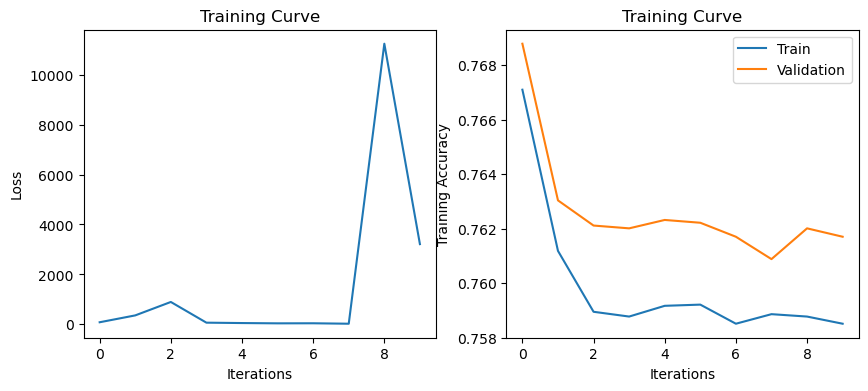

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

## Embeddingi

In [24]:
class Adults_classifier_embeddings(nn.Module):
    def __init__(self, size_1=40, size_2=20):
        super(Adults_classifier_embeddings, self).__init__()
        self.emb_layer = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.layer1 = nn.Linear(adults_data.shape[1] -1 + categorical_data.shape[1], size_1)
        self.bn1 = nn.BatchNorm1d(size_1)                   # added BatchNorm1d there
        self.act_1 =  nn.LeakyReLU()
        self.d1 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(size_1, size_2)
        self.act_2 =  nn.LeakyReLU()
        self.d2 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(size_2, 1)
    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)
        activation1 = self.act_1(self.bn1(self.layer1(x)))  # added BatchNorm1d there
        activation1 = self.d1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.d2(activation2)
        output = self.layer3(activation2)
        return output

In [25]:
model = Adults_classifier_embeddings().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train() 
        out = model(x, cat_x).squeeze()           

        loss = criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()              
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 0.595 test_acc: 0.761
Epoch 1 loss 0.548 test_acc: 0.761
Epoch 2 loss 0.534 test_acc: 0.767
Epoch 3 loss 0.513 test_acc: 0.778
Epoch 4 loss 0.509 test_acc: 0.781


In [ ]:
labels_numpy_array = test_dataset.tensors[2].cpu().detach().numpy()
pd.DataFrame(labels_numpy_array).describe()

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

In [ ]:
preds = model(test_numerical_data.to(device),test_categorical_data.to(device))
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-2,2));
# preds.cpu().detach().numpy() is a way of converting tensor to numpy array
# the difference is that numpy array does not contain computational graph
# that allows for calculating gradient using chain rule for derivative

In [ ]:
(preds>0).sum()

# Ważenie przykładów

In [ ]:
model = Adults_classifier_embeddings().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss(pos_weight=(len(targets)-sum(targets))/sum(targets))
# ^ that's the difference between embedding and this (wazenie przykladow)
optimizer = optim.Adam(model.parameters(), lr=0.1)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(20):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train() 
        out = model(x, cat_x).squeeze()           

        loss = criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        optimizer.step()              
        optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

In [ ]:
preds = model(test_numerical_data.to(device),test_categorical_data.to(device))
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-1,2));

In [ ]:
(preds>0).sum()

# Hyperparameters tuning

In [ ]:
def fast_accuracy(model, validation_dataset):
    with torch.no_grad():
        correct = 0
        total = 0
        model.eval()
        x, cat_x, labels = validation_dataset.tensors
        output = model(x.to(device), cat_x.to(device))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred).to(device)).sum().item()
        total += x.shape[0]
    return correct / total

def train_search(model, train_dataset, validation_dataset, batch_size=1024, num_epochs=1, learn_rate=0.1, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # shuffle after every epoch
    criterion = nn.BCEWithLogitsLoss(pos_weight=(len(targets)-sum(targets))/sum(targets))
    optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)
    # optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    idx = 0
    for n in range(num_epochs):
        # for imgs, labels in iter(train_loader):
        for x, cat_x, labels in iter(train_loader):
            # imgs, labels = imgs.to(device), labels.to(device)
            x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
            model.train()
            # out = model(imgs)
            out = model(x, cat_x).squeeze()          
            loss = criterion(out, labels) 
            loss.backward()               
            optimizer.step()              
            optimizer.zero_grad()         

    return(fast_accuracy(model, validation_dataset))

In [ ]:
# first_layer = [20000, 10000, 5000, 2000, 1000, 500, 100, 50, 10]
# second_layer = [20000, 10000, 5000, 2000, 1000, 500, 100, 50, 10]
first_layer = [1000, 500, 100, 50, 10]
second_layer = [1000, 500, 100, 50, 10]
results = pd.DataFrame()
# torch.cat([batch[0] for batch in mnist_val]), torch.tensor([batch[1] for batch in mnist_val])
# test_dataset_reshaped = torch.cat([batch[0] for batch in test_dataset]), torch.cat([batch[1] for batch in test_dataset]), torch.tensor([batch[2] for batch in test_dataset])
# ^ .cat dla x, .cat dla cat_x, .tensor dla target (label)
for i in range(len(first_layer)):
    for j in range(len(second_layer)):
        model = Adults_classifier_embeddings(first_layer[i],second_layer[j]).to(device)
        val_acc = train_search(model, train_dataset, test_dataset, num_epochs=20)
        print(first_layer[i],second_layer[j],val_acc)
        results = results.append({"first": first_layer[i], "second": second_layer[j],"acc":val_acc},ignore_index=True)

In [ ]:
import datetime
now = datetime.datetime.now()
results.to_csv(f"adults_classifier_params_search{now}.csv",index=False)
results = pd.read_csv(f"adults_classifier_params_search{now}.csv")

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(results["first"], results["second"], c=np.exp(results.acc*100), cmap="YlGn", s=1000)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("First layer")
plt.ylabel("Second layer")
for idx, row in results.iterrows():
    ax.annotate(str(row.acc)[:5], (row["first"]*0.82, row["second"]))
plt.show()